Aim is the comparison of different forward operators:
* the pyGIMLi built-in EM1dModelling using the quasi-static approximation (Ward & Hohmann, 1989)
* the Python-implementation for HEM taking dielectric displacement into account (Siemon, 2012)
* the very general empymod implementation by Werthmüller et al. (2017)

In [1]:
import numpy as np
import pygimli as pg
from pygimli.physics.em.fdem import HEMmodelling
import empymod

Both pyGIMLi-based forward operators yield the ratio of secondary to primary field, which is defined by (Ward & Hohmann, 1989)
$$ H_z = \frac{1}{4\pi r^3} $$
Note that EM1dModelling was designed for ground EM and yields Hs/Hp in percent, whereas HEMModelling was designed for the HEM system that measures Hs/Hp in ppm.

We consider a frequency sounding using a classical HCP (vertical magnetic dipole transmitter and receiver at the same level) configuration.

In [2]:
coilspacing = 100.  # typical distance
freq = 2**np.arange(10) * 110.  # MaxMin/Promys system
height = 1  # carried by
fak = 100.  # results as % of primary field

In [3]:
# Alternatively, we can use a typical airborne case like the RESOLVE bird:
if 0:
    coilspacing = 10.  # RESOLVE bird dimension
    # freq = np.array([387., 1820., 8330., 41500., 133400.])
    fak = 1e6  # typically in ppm
    height = 50.  # typical flight elevation 

Model is a three-layer model as in pyGIMLi (d1, d2, rho1, rho2, rho3) that can be formulated without (default) or with air.

In [4]:
def addAir(model, height, resAir=1e14):
    """Generate model including air."""
    nlay = (len(model)+1) // 2
    return np.concatenate(([height], model[:nlay-1], [resAir], model[nlay-1:]))

model = [20, 20, 200, 1000, 30]
modelAir = addAir(model, height)
nlay = (len(model)+1) // 2

In [5]:
fop1 = pg.core.FDEM1dModelling(nlay, freq, coilspacing, height)
fas = (coilspacing**-3)/4/np.pi
fafak = fop1.freeAirSolution()[0] / fas  # bug in freeAir (pgcore<1.4)
resp1 = fop1(model) / 100 * fak * fafak  # returns %, remove fafak reveals bug for heights>>0
fop1b = pg.core.FDEM1dModelling(nlay+1, freq, coilspacing, 0.0)
resp1b = fop1b(modelAir) / 100 * fak  # returns %
fop2 = HEMmodelling(nlay, height, f=freq, r=coilspacing)
resp2 = fop2(model) / 1e6 * fak  # returns ppm
fop2b = HEMmodelling(nlay+1, 0.1, f=freq, r=coilspacing)
resp2b = fop2b(modelAir) / 1e6 * fak  # returns ppm

In [6]:
def showSounding(f, resp, ax=None, **kwargs):
    """Show FDEM sounding."""
    if ax is None:
        fig, ax = pg.plt.subplots(ncols=2, sharey=True)

    ip, op = np.split(resp, 2)
    ax[0].semilogy(ip, f, **kwargs)
    ax[1].semilogy(op, f, **kwargs)
    ax[0].set_ylim(min(f), max(f))
    ax[0].grid(True)
    ax[1].grid(True)
    return ax

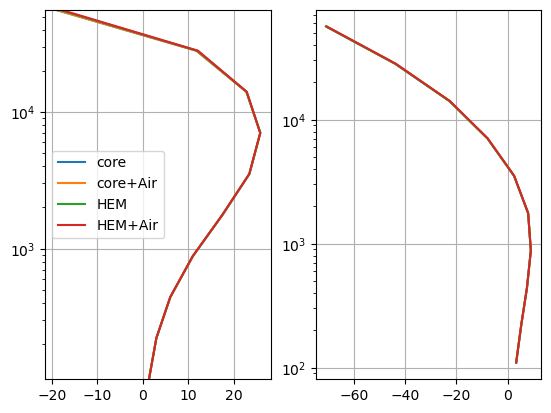

In [7]:
fig, ax = pg.plt.subplots(ncols=2)
showSounding(freq, resp1, ax=ax, label="core")
showSounding(freq, resp1b, ax=ax, label="core+Air")
showSounding(freq, resp2, ax=ax, label="HEM")
showSounding(freq, resp2b, ax=ax, label="HEM+Air")
ax[0].legend();

In [8]:
print(np.column_stack([resp1, resp1b, resp2, resp2b]))

[[  1.35059282   1.35059282   1.35059217   1.34921688]
 [  2.9758696    2.9758696    2.9758678    2.97218406]
 [  6.04466399   6.04466399   6.04466034   6.03578925]
 [ 11.02951309  11.02951309  11.02951207  11.01112295]
 [ 17.52649276  17.52649276  17.52653122  17.49592646]
 [ 23.48743815  23.48743815  23.48768807  23.45208574]
 [ 25.89169193  25.89169193  25.8928015   25.87720796]
 [ 22.82343409  22.82343409  22.87410122  22.91251877]
 [ 11.81507458  11.81507458  12.01680593  12.1693175 ]
 [-19.28815676 -19.28815676 -18.517901   -18.13888601]
 [  3.34701391   3.34701391   3.3470143    3.34329052]
 [  5.30556824   5.30556824   5.30556994   5.2995901 ]
 [  7.55062615   7.55062615   7.55063291   7.5428553 ]
 [  9.06801873   9.06801873   9.06804233   9.06276208]
 [  8.00580662   8.00580662   8.00587507   8.01549383]
 [  2.49928444   2.49928444   2.49943436   2.54595789]
 [ -7.87424394  -7.87424394  -7.87407949  -7.7669585 ]
 [-22.68391501 -22.68391501 -22.68333825 -22.50051586]
 [-43.8968

We now want to build the operator using empymod.

In [13]:
class HCPModellingEMP(pg.frameworks.Modelling):
    """Modelling a HCP coil-coil system by empymod."""

    def __init__(self, freq, coilspacing, height=0):
        """Initialize by saving parameters."""
        super().__init__()
        self.coilspacing = coilspacing
        self.freq = freq
        self.height = height
        self.freeAir = (coilspacing**-3)/4/np.pi

    def response(self, model):
        """Forward response for layered block model."""
        nlay = (len(model)+1) // 2
        thk = model[:nlay-1]
        res = model[nlay-1:]
        assert len(res), len(thk)+1
        inp = dict(res=np.concatenate(([2e14], res)),
                   depth=np.concatenate(([0.1], np.cumsum(thk))),
                   freqtime=self.freq,
                   src=[0, 0, -height],
                   rec=[self.coilspacing, 0, -height],
                   ab=66, squeeze=True, verb=1, xdirect=True,
                   htarg={'pts_per_dec': 0, 'dlf': 'key_51_2012'}
                  )
        print(inp)
        out = empymod.dipole(**inp) / self.freeAir
        print(out)
        return np.concatenate([out.real, out.imag])
    
fop3 = HCPModellingEMP(freq, coilspacing, height=height)
re = fop3.response([10000])  # should be mainly real-valued primary field

{'res': array([2.e+14, 1.e+04]), 'depth': array([0.1]), 'freqtime': array([  110.,   220.,   440.,   880.,  1760.,  3520.,  7040., 14080.,
       28160., 56320.]), 'src': [0, 0, -1], 'rec': [100.0, 0, -1], 'ab': 66, 'squeeze': True, 'verb': 1, 'xdirect': True, 'htarg': {'pts_per_dec': 0, 'dlf': 'key_51_2012'}}
[-0.24438728+1151.38249883j -0.24208833 +575.69611068j
 -0.23884374 +287.85480996j -0.23426978 +143.93672036j
 -0.22783541  +71.98107856j -0.21923734  +36.00987196j
 -0.21630088  +18.02968438j -0.18319489   +9.0368043j
 -0.17077026   +4.5635719j  -0.13529633   +2.30358066j]


{'res': array([2.e+14, 2.e+02, 1.e+03, 3.e+01]), 'depth': array([ 0.1, 20. , 40. ]), 'freqtime': array([  110.,   220.,   440.,   880.,  1760.,  3520.,  7040., 14080.,
       28160., 56320.]), 'src': [0, 0, -1], 'rec': [100.0, 0, -1], 'ab': 66, 'squeeze': True, 'verb': 1, 'xdirect': True, 'htarg': {'pts_per_dec': 0, 'dlf': 'key_51_2012'}}
[-38.53806276+1166.92496915j -30.54613503 +592.81679715j
 -21.73855248 +305.23909472j -13.05791547 +159.7911041j
  -5.77091058  +84.56860443j  -0.91207673  +44.43017502j
   1.3924032   +22.65022005j   2.03141929  +11.04461093j
   1.9556727    +5.04255188j   1.58708986   +1.81127667j]


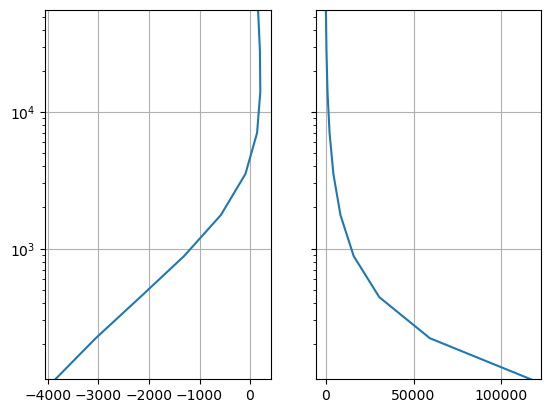

In [11]:
resp3 = fop3.response(model) * fak
showSounding(freq, resp3);

### References
* Ward, S. H., and G. W. Hohmann, 1987, Electromagnetic theory for geophysical applications, in M. N. Nabighian, ed., Electromagnetic methods in applied geophysics, 1: Theory, SEG, 130–310. 
* Siemon, B. (2012): Accurate 1D forward and inverse modeling of high-frequency helicopter-borne electromagnetic data, Geophysics 77(4), WB71-87.
* Werthmüller, D. (2017): An open-source full 3D electromagnetic modeler for 1D VTI media
in Python: empymod, Geophysics 82(6), WB9-19.